# Calculating transition amplitudes by variational quantum deflation

## Overview

# Generate Hamiltonian of AB (azobenzene)

In [46]:
from openfermion.chem import geometry_from_pubchem
from quri_parts.chem import cas
from quri_parts.pyscf.mol import get_spin_mo_integrals_from_mole
from quri_parts.openfermion.mol import get_qubit_mapped_hamiltonian
from pyscf import gto, scf, mcscf, cc, ci

# Get molecule geometry (atomic species and coordinates) from PubChem database
atom = geometry_from_pubchem("azobenzene")
# Build pyscf molecule object with nuclei, electrons, etc...
mole = gto.M(atom=atom) 
# Perform Restricted Hartree-Fock (RHF) to compute molecular orbitals and Hartree–Fock energy
mf = scf.RHF(mole).run() 

# Define Complete Active Space (CAS): 4 electrons distributed in 4 orbitals
# Take sub-system of the entire molecule to make computation easier.
active_space = cas(4, 4)

# Compute molecular integrals in the chosen active space,
# build the Fermionic Hamiltonian,
# and map it to a Qubit Hamiltonian (default: Jordan–Wigner mapping).
hamiltonian, mapping = get_qubit_mapped_hamiltonian(
    *get_spin_mo_integrals_from_mole(mole, mf.mo_coeff, active_space)
)

converged SCF energy = -562.053344724962


## Compute exact excited state by CASCI with PySCF.

### Complete Active Space Configuration Interaction (CASCI)
**Configuration Interaction (CI)** is one of a **post-Hartree–Fock method** for solving the electronic Schrödinger equation within the Born-Oppenheimer approximation for a quantum chemical multi-electron system. <br>
It goes beyond the single-determinant Hartree–Fock approximation by including **electron correlation effects** through a variational wave functions, which is written as a **linear combination of configuration state functions (CSFs)**,  <br>
$\Psi = \sum_{I} c_I \Phi_I$
where:
- $\Phi_I$ are many-electron basis states (determinants or CSFs),
- $c_I$ are variational coefficients optimized by diagonalizing the Hamiltonian.

---

### CASCI
**CASCI** performs a full CI but only **within the chosen active space**: <br>
- Inactive orbitals (always doubly occupied) and virtual orbitals (always empty) are frozen,  
- Active orbitals allow the chosen number of active electrons to be distributed in all possible ways.  

This makes CASCI to capture the **static (strong) correlation** among active orbitals.

---

### PySCF Implementation
In PySCF, `mcscf.CASCI` constructs the CASCI solver.  
Setting `mc.fcisolver.nstates = N` requests multiple low-lying excited states by diagonalizing the Hamiltonian within the active space.

---

In [47]:
mc = mcscf.CASCI(mf, active_space.n_active_orb, active_space.n_active_ele)
mc.fcisolver.nstates = 6 # Compute ground state + 5 excited states
mc.kernel(verbose=0)
mc.e_tot

CASCI state   0  E = -562.057671219961  E(CI) = -2.20745364895095  S^2 = 0.0000000
CASCI state   1  E = -561.829824515090  E(CI) = -1.97960694408050  S^2 = 2.0000000
CASCI state   2  E = -561.812652554591  E(CI) = -1.96243498358137  S^2 = 0.0000000
CASCI state   3  E = -561.752682574616  E(CI) = -1.90246500360570  S^2 = 2.0000000
CASCI state   4  E = -561.747970360662  E(CI) = -1.89775278965180  S^2 = 2.0000000
CASCI state   5  E = -561.740607983117  E(CI) = -1.89039041210697  S^2 = 0.0000000


array([-562.05767122, -561.82982452, -561.81265255, -561.75268257,
       -561.74797036, -561.74060798])

# Compute ground state by UCCSD
## Coupled Cluster Singles and Doubles (CCSD)
**Coupled cluster (CC)** is another **post-HF method** in Quantum chemistry. <br>
Unlike CI takes linear combination configuration state functions, CC uses the exponential cluster operator for considering electron correlation, <br>
$\Psi = e^T \Phi$ <br>
where:
- T: Cluster operator.
- $\Phi$: Slater determinant of CI.

### Cluster operator
**Cluster operator (T)** is written in the form of $T = T_1 + T_2 + T_3 \dots$, where $T_1$ is single excitation, $T_2$ is double excitation, etc. Which in the second quantization formalism can be written as, <br>
- $T_1 = \sum_{i, a} t_i^a a^\dagger_a a_i$, 
- $T_2 = \frac{1}{4} \sum_{ij, ab} t_{ij}^{ab} a^\dagger_a a^\dagger_b a_j a_i$
- $T_n = \frac{1}{(n!)^2} \sum_{i_1, \dots, i_n, a_1, \dots, a_n} a^\dagger_{a_1} \dots a^\dagger_{a_n} a_{i_n} \dots a_{i_1}$

In **CCSD**, only $T_1$ and $T_2$ are considerated.

The benefit of adopting exponential instead of linear combination is exponential guarentees the **size extensivity** of the solution. Take CCSD for example:
$T = T_1 + T_2$, <br>
$e^{(T_1+T_2)} = (T_1+T_2) + \frac{1}{2!} (T_1+T_2)^2 + \frac{1}{3!} (T_1+T_2)^3 ...$
Even if $T$ only includes singles and doubles ($T_1 + T_2$), the exponential generates **higher-order excitations automatically**.

### Coupled-cluster equations
Schrödinger equation: $H \ket{\Psi} = E \ket{\Psi} \to H e^T \ket{\Phi} = E e^T \ket{\Phi}$

The unknown parameters ($t_i^a, t_{ij}^{ab} \dots$) can be solved from following equation sets (CCSD):
- $\bra{\Phi_0} e^{-(T_1+T_2)} H e^{(T_1+T_2)} \ket{\Phi_0} = E$
- $\bra{\Phi_i^a} e^{-(T_1+T_2)} H e^{(T_1+T_2)} \ket{\Phi_0} = 0$
- $\bra{\Phi_{ij}^{ab}} e^{-(T_1+T_2)} H e^{(T_1+T_2)} \ket{\Phi_0} = 0$

After solving these equation sets, we get $\{t_i^a\} \ \text{and} \ \{ t_{ij}^{ab} \}$.

---

In [48]:
from quri_parts.chem.mol.models import OrbitalType
from quri_parts.chem.mol import ActiveSpaceMolecularOrbitals
from quri_parts.pyscf.mol import PySCFMolecularOrbitals

asmo = ActiveSpaceMolecularOrbitals(
    PySCFMolecularOrbitals(mole, mf.mo_coeff), active_space
)

forzen_orbs = [i for i in range(mole.nao) if asmo.orb_type(i) != OrbitalType.ACTIVE]

ccsd = cc.CCSD(mf, frozen=forzen_orbs).run(verbose=0)

## From CCSD to UCCSD
On a quantum computer, one uses a **unitary coupled cluster (UCC)** ansatz to maintain unitarity:

$
|\Psi_{\text{UCC}}\rangle = e^{T - T^\dagger} |\Phi_0\rangle
$

- This guarantees a **variational wavefunction**, suitable for variational quantum eigensolver (VQE) algorithms.  
- In practice, **UCCSD** (unitary singles and doubles) is the most common choice.  
- The CCSD amplitudes from classical computation are often used as **initial parameters** for the UCCSD circuit on a quantum computer.

---

In [49]:
from typing import Sequence
import numpy as np
import numpy.typing as npt
from quri_parts.openfermion.ansatz import TrotterUCCSD

def ccsd_param_to_circuit_param(
    uccsd: TrotterUCCSD,
    n_electrons: int,
    t1: npt.NDArray[np.complex128],
    t2: npt.NDArray[np.complex128],
) -> Sequence[float]:
    in_param_list = uccsd.param_mapping.in_params
    param_list = []

    for param in in_param_list:
        name_split = param.name.split("_")
        if name_split[0] == "s":
            _, i_str, j_str = name_split
            i, j = int(i_str), int(j_str) - n_electrons // 2
            param_list.append(t1[i, j])

        if name_split[0] == "d":
            _, i_str, j_str, a_str, b_str = name_split
            i, j, b, a = (
                int(i_str),
                int(j_str),
                int(b_str) - n_electrons // 2,
                int(a_str) - n_electrons // 2,
            )
            param_list.append(t2[i, j, a, b])
    return param_list

from quri_parts.core.state import quantum_state, apply_circuit

TROTTER_STEPS = 1
USE_SINGLES = True
REDUCE_PARAMETER = True

uccsd = TrotterUCCSD(
    active_space.n_active_orb * 2,
    active_space.n_active_ele,
    trotter_number=TROTTER_STEPS,
    use_singles=USE_SINGLES,
    singlet_excitation=REDUCE_PARAMETER,
)
param = ccsd_param_to_circuit_param(uccsd, active_space.n_active_ele, ccsd.t1, ccsd.t2)
hf_state = quantum_state(active_space.n_active_orb * 2, bits=2**active_space.n_active_ele - 1)
state = apply_circuit(uccsd, hf_state)
uccsd_bound_state = state.bind_parameters(param)


# Quantum Selected Configuration Interaction (QSCI)

With a initial parameters from CCSD, we can apply Quantum Selected Configuration Interaction (QSCI) to obtain ground state and ground state energy.

---

In [50]:
from quri_parts.qulacs.sampler import create_qulacs_general_vector_sampler
from quri_parts_qsci import qsci

BASIS_STATES = None
TOTAL_SHOTS = 10000

sampler = create_qulacs_general_vector_sampler()

eigs, _ = qsci(
    hamiltonian, [uccsd_bound_state], sampler, total_shots=TOTAL_SHOTS, num_states_pick_out=BASIS_STATES
)

print(eigs)

[-562.05764034]


## Excited-state cost function
After getting ground state energy, we want to go further to compute excited state energy. <br>
To achieve this, we design a cost function based on **Quantum Subspace Configuration Interaction (QSCI)**. The main idea is to embed the candidate excited state together with already known low-energy states into a finite-dimensional subspace and then diagonalize the Hamiltonain within this subspace.

### Procedure
1. Generate a candidate excited state with random parameters.
2. Form the subspace basis with combining fixed states + new trial state.
3. Apply **QSCI** to obtain a set of parameter s.t. minimize the total energy to produce the correct spectrum.

---

In [51]:
from typing import Callable
from quri_parts.core.sampling import ConcurrentSampler
from quri_parts.core.operator import Operator
from quri_parts.core.state import CircuitQuantumState

def create_state(bits: int, params: npt.NDArray[np.float64]) -> CircuitQuantumState:
    approx_circuit = uccsd.bind_parameters(params)
    approx_exc_state = quantum_state(approx_circuit.qubit_count, circuit=approx_circuit, bits=bits)
    return approx_exc_state

def get_cost(
    exc_bits: int, 
    sampler: ConcurrentSampler, 
    hamiltonian: Operator, 
    fixed_state: Sequence[CircuitQuantumState]
) -> Callable[[npt.NDArray[np.float64]], float]:
    def f(x: npt.NDArray[np.float64]) -> float:
        approx_exc_state = create_state(bits=exc_bits, params=x)
        quantum_states = fixed_state + [approx_exc_state]
        vals, vecs = qsci(
            hamiltonian,
            quantum_states,
            sampler,
            total_shots=TOTAL_SHOTS,
            num_states_pick_out=BASIS_STATES
        )
        return np.sum(vals)

    return f

## Sequential excited-state search with QSCI  

This is the procedure for computing excited states sequentially using the QSCI-based cost function.  
An important note is that the optimizer cannot be a gradient-descent method.  
This is because the cost function is defined through **subspace diagonalization**, which involves an eigenvalue problem.  
The resulting cost is **non-analytic** and generally **non-smooth**, meaning gradients are not reliable or even well-defined.  
Therefore, we employ **gradient-free optimizers** (e.g., COBYLA, Nelder–Mead, or Powell).  

---



In [52]:
from scipy.optimize import minimize

sampler = create_qulacs_general_vector_sampler()

exc_masks = [0 for _ in range(5)]
fixed_state = [uccsd_bound_state]

for exc_mask in exc_masks:
    bits = (2**active_space.n_active_ele - 1) ^ exc_mask
    cost = get_cost(
        exc_bits=bits,
        sampler=sampler,
        hamiltonian=hamiltonian,
        fixed_state=fixed_state
    )

    bounds = [(-10**-1, 10**-1) for _ in range(uccsd.parameter_count)]
    sol = minimize(
        cost,
        x0=np.random.uniform(-10**-2, 10**-2, uccsd.parameter_count),
        method="COBYLA",
        bounds=bounds,
        options={"maxiter": 50, "disp": True}
    )

    excited_state = quantum_state(
        active_space.n_active_orb * 2, bits=bits, circuit=uccsd.bind_parameters(sol.x)
    )
    fixed_state.append(create_state(bits, params=sol.x))



   Return from subroutine COBYLA because the MAXFUN limit has been reached.

   NFVALS =   50   F =-1.123886E+03    MAXCV = 9.714451E-17
   X = 3.496193E-02   5.609843E-02   6.924859E-02   7.070362E-02  -1.000000E-01
       1.000000E-01   2.190549E-03   1.000000E-01  -9.586199E-02  -1.000000E-01
      -1.000000E-01  -8.774120E-02  -1.000000E-01  -1.000000E-01

   Return from subroutine COBYLA because the MAXFUN limit has been reached.

   NFVALS =   50   F =-1.685700E+03    MAXCV = 4.163336E-17
   X =-1.000000E-01  -1.000000E-01  -1.000000E-01  -1.000000E-01  -1.000000E-01
      -3.750016E-02  -1.000000E-01  -1.000000E-01  -1.000000E-01   1.000000E-01
      -1.000000E-01   1.000000E-01  -9.985844E-02  -1.000000E-01

   Return from subroutine COBYLA because the MAXFUN limit has been reached.

   NFVALS =   50   F =-2.247453E+03    MAXCV = 4.163336E-17
   X = 1.000000E-01   4.106886E-02   5.784781E-02   1.000000E-01   5.265746E-02
       4.139786E-02   4.251042E-02   4.239979E-02   6.12

## Plotting - Compare CASCI result and QSCI result

/tmp/ipykernel_3646684/3966175584.py:40: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x_pos, cis_qc[i], color=colors[i], edgecolor='black', marker=markers[i], zorder=5)


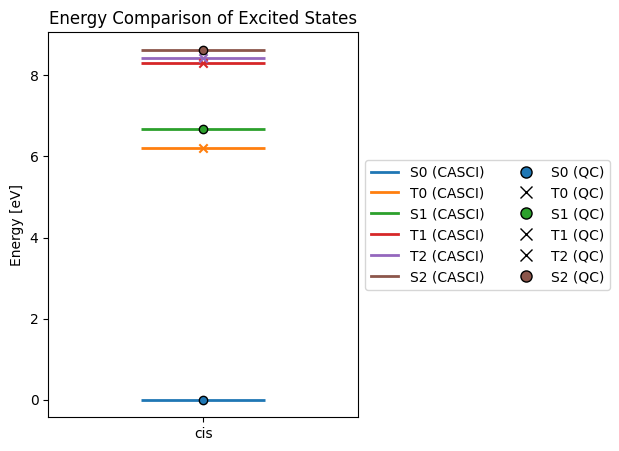

In [58]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

cis_exact = mc.e_tot
cis_qc    = qsci(hamiltonian, fixed_state, sampler, TOTAL_SHOTS, BASIS_STATES)[0]

multiplicity_info = [round(mc.fcisolver.spin_square(mc.ci[i], mc.ncas, mc.nelecas)[1]) for i in range(mc.fcisolver.nstates)]

labels = []
markers = []
colors = plt.cm.tab10.colors
count_dict = {}

for mult in multiplicity_info:
    if mult == 1:
        prefix, marker = "S", "o"
    elif mult == 3:
        prefix, marker = "T", "x"
    elif mult == 5:
        prefix, marker = "Q", "^"
    elif mult == 7:
        prefix, marker = "H", "s"
    else:
        prefix, marker = f"M{mult}", "d"

    idx = count_dict.get(prefix, 0)
    labels.append(f"{prefix}{idx}")
    markers.append(marker)
    count_dict[prefix] = idx + 1

cis_exact = (cis_exact - cis_exact[0])*27.21 # Change to eV
cis_qc = (cis_qc - cis_qc[0])*27.21

fig, ax = plt.subplots(figsize=(4, 5))
x_pos = 1.0
width = 0.08

for i in range(len(labels)):
    ax.hlines(cis_exact[i], x_pos - width, x_pos + width, color=colors[i], lw=2)
    ax.scatter(x_pos, cis_qc[i], color=colors[i], edgecolor='black', marker=markers[i], zorder=5)

handles_casci = [Line2D([0], [0], color=c, lw=2, label=f"{l} (CASCI)")
                 for c, l in zip(colors, labels)]
handles_qc = [Line2D([0], [0], color=c, marker=m, linestyle='None',
                     markeredgecolor="black", markersize=8, label=f"{l} (QC)")
              for c, m, l in zip(colors, markers, labels)]

handles = handles_casci + handles_qc

ax.legend(handles=handles, ncol=2, loc='center left', bbox_to_anchor=(1.0, 0.5))

ax.set_xlim(0.8, 1.2)
ax.set_xticks([x_pos])
ax.set_xticklabels(["cis"])
ax.set_ylabel("Energy [eV]")
ax.set_title("Energy Comparison of Excited States")

plt.show()


## Appendix (A): Jordan-Wigner mapping

## Appendix (B): Configuration Interaction Singles and Doubles(CISD)